<H1>SKIN LESIONS/CANCER DETECTION</H1>

<H2>EDA ON THE HAM10000 DATASET</H2>

To perform Exploratory Data Analysis (EDA) on the HAM10000 dataset, we will first examine its structure and understand its key components.

<h3>Dataset Overview</h3>

The HAM10000 dataset consists of:   10,015 images of skin lesions in JPEG format

7 classes of skin lesions:

*nv: Melanocytic nevi (benign)

*mel: Melanoma (malignant)

*bkl: Benign keratosis-like lesions (benign)

*bcc: Basal cell carcinoma (malignant)

*akiec: Actinic keratoses and intraepithelial carcinoma (malignant)

*vasc: Vascular lesions (benign)

*df: Dermatofibroma (benign)

Metadata file with information such as lesion type, diagnosis confirmation type, and patient demographics.


<h3>Analyzing the Metadata </h3>

In [28]:
df = pd.read_csv(r"C:\Users\User\Desktop\HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [32]:
print(df.dx.value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


We can see the class imbalance of the dataset

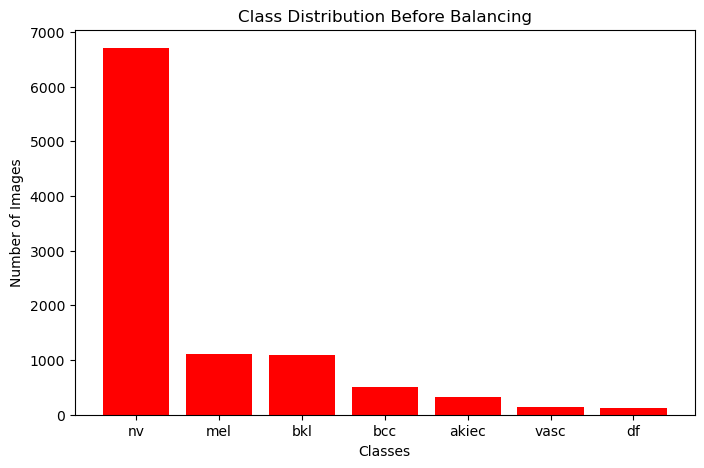

In [45]:
import matplotlib.pyplot as plt

# Example data for class distribution
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
sample_counts = [ 6705, 1113,  1099,  514,  327, 142,  115] 

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(class_names, sample_counts, color='red')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution Before Balancing')
plt.show()


The dataset is highly imbalanced

As the dataset is imbalanced we have to balance it by using Random Sampling with Replacement
<h4>Sampling with replacement</h4> means that an image from a class can be selected more than once. This is useful when a class has fewer images than the desired number of samples (in this case, 500 images per class)

This method of balancing is <b>oversampling</b> because it may duplicate images for classes that originally had fewer images, while it may leave some of the class's original images out if there were too many. It doesn't change the number of classes, just the number of samples per class.

Code for balancing the imbalanced dataset

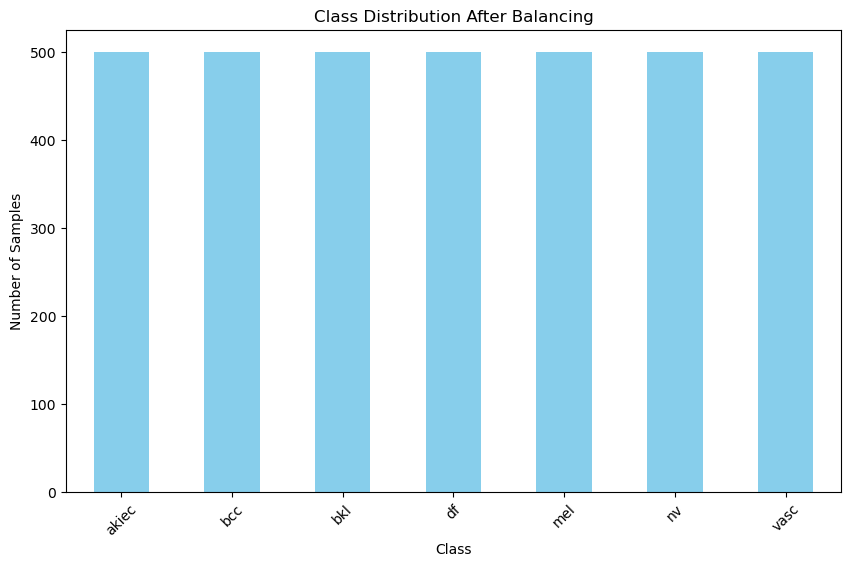

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Path to dataset
data_dir = r"C:\Users\User\Desktop\dataset"

# Create a balanced dataset DataFrame
def create_sample_df(dataset_dir, samples_per_class=100):
    all_data = []
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
            sampled_files = np.random.choice(image_files, samples_per_class, replace=len(image_files) < samples_per_class)
            all_data.extend([(img, class_name) for img in sampled_files])
    return pd.DataFrame(all_data, columns=["image", "label"])

# Create the balanced dataset with 500 samples per class
sample_df = create_sample_df(os.path.join(data_dir, 'train'), samples_per_class=500)

# Function to visualize the class distribution in a bar graph
def visualize_class_distribution(df):
    # Count the number of samples per class
    class_counts = df['label'].value_counts()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title("Class Distribution After Balancing")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

# Visualize the class distribution
visualize_class_distribution(sample_df)


Comparing Class Distribution after Balancing and Class Distribution before Balancing

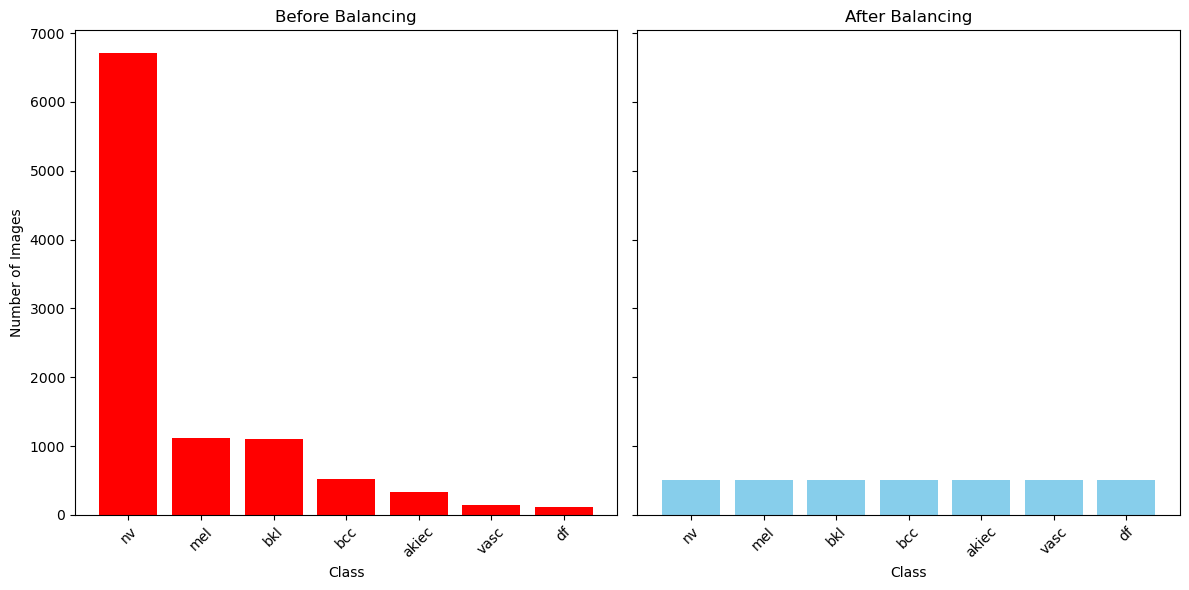

In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate data directories and counts (replace this with actual data directories)
class_counts_before = {'nv': 6705, 'mel': 1113, 'bkl': 1099, 'bcc': 514, 'akiec': 327, 'vasc': 142, 'df': 115}
classes = list(class_counts_before.keys())
counts_before = list(class_counts_before.values())

# Balanced dataset (after oversampling or equal sampling)
samples_per_class = 500  
counts_after = [samples_per_class] * len(classes)

# Create the bar plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before balancing
ax[0].bar(classes, counts_before, color='red')
ax[0].set_title("Before Balancing")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Images")
ax[0].tick_params(axis='x', rotation=45)

# After balancing
ax[1].bar(classes, counts_after, color='skyblue')
ax[1].set_title("After Balancing")
ax[1].set_xlabel("Class")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<h3> Image Preprocessing</h3>
    
Image preprocessing is essential to ensure consistent input to the model. Common steps include:

<h5>Resizing:</h5>Standardize all images to the same size (e.g., 224x224).

<h5>Normalization:</h5> Scale pixel values to [0, 1] or normalize using the dataset's mean and standard deviation.

<h5>Data Augmentation:</h5>

Horizontal and vertical flips.

Random rotations and zooms.

Color jittering (brightness, contrast, etc.).

Random cropping

<H5>Code for Image Preprocessing and Augmentation</H5>


Testing training transformation...
Loading image from: C:\Users\User\Desktop\ISIC_0024372.jpg
Image loaded successfully.
Image preprocessing completed successfully.
Processed image shape: torch.Size([3, 224, 224])

Testing validation/test transformation...
Loading image from: C:\Users\User\Desktop\ISIC_0024372.jpg
Image loaded successfully.
Image preprocessing completed successfully.
Processed image shape: torch.Size([3, 224, 224])


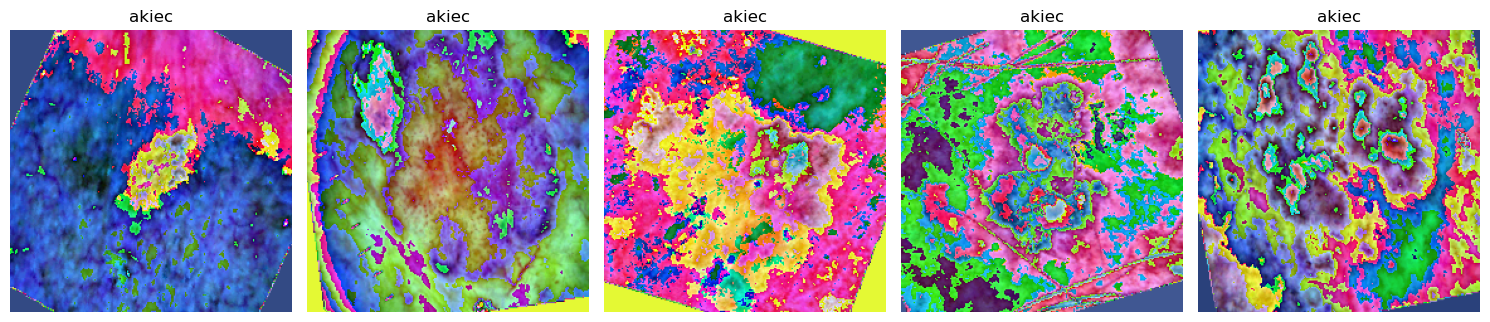

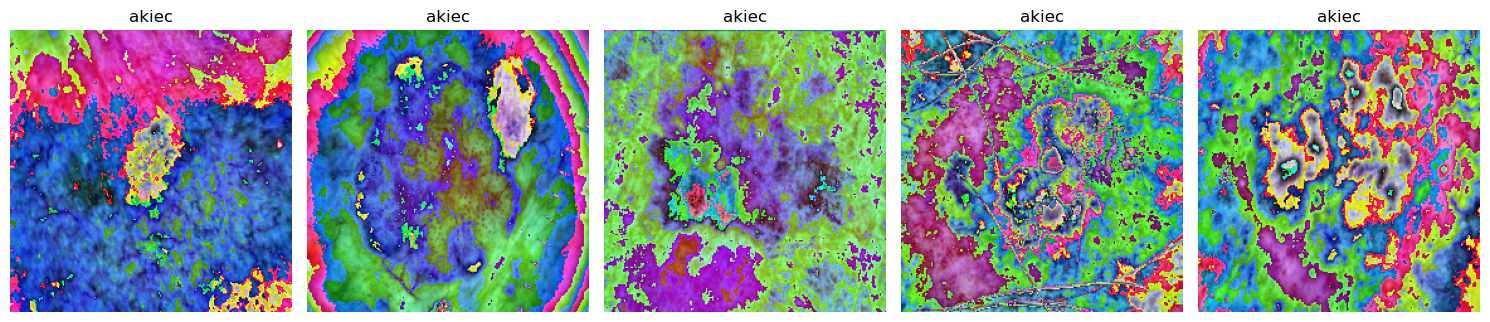

In [129]:
from torchvision import transforms

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

# Example function to test preprocessing
def test_preprocessing(transform, image_path):
    from PIL import Image

    print(f"Loading image from: {image_path}")
    try:
        img = Image.open(image_path).convert('RGB')  # Open image
        print("Image loaded successfully.")
        processed_img = transform(img)  # Apply transformation
        print("Image preprocessing completed successfully.")
        print(f"Processed image shape: {processed_img.shape}")
    except Exception as e:
        print(f"Error during preprocessing: {e}")

# Path to a sample image for testing
sample_image_path = r"C:\Users\User\Desktop\ISIC_0024372.jpg"

# Test the training transformation
print("\nTesting training transformation...")
test_preprocessing(data_transforms['train'], sample_image_path)

# Test the validation/test transformation
print("\nTesting validation/test transformation...")
test_preprocessing(data_transforms['val_test'], sample_image_path)



# Function to visualize augmented images
def visualize_augmented_images(sample_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    transform = data_transforms['train']  # Augmentation transformation for training
    
    for i, ax in enumerate(axes):
        img_path = sample_df.iloc[i]["image"]
        label = sample_df.iloc[i]["label"]
        
        # Open the image using PIL
        img = Image.open(img_path)
        
        # Apply transformations to the image
        img_transformed = transform(img)
        
        # Convert the tensor back to a PIL image for visualization
        img_transformed = transforms.ToPILImage()(img_transformed)
        
        # Display the image and its label
        ax.imshow(img_transformed)
        ax.set_title(label)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Function to visualize preprocessed images
def visualize_preprocessed_images(sample_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    transform = data_transforms['val_test']  # Preprocessing transformations for validation/testing
    
    for i, ax in enumerate(axes):
        img_path = sample_df.iloc[i]["image"]
        label = sample_df.iloc[i]["label"]
        
        # Open the image using PIL
        img = Image.open(img_path)
        
        # Apply preprocessing (resize, normalize)
        img_transformed = transform(img)
        
        # Convert the tensor back to a PIL image for visualization
        img_transformed = transforms.ToPILImage()(img_transformed)
        
        # Display the image and its label
        ax.imshow(img_transformed)
        ax.set_title(label)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_augmented_images(sample_df, num_images=5)  # Visualizing augmented images
visualize_preprocessed_images(sample_df, num_images=5)  # Visualizing preprocessed images



<h5>Sample images of seven types of skin lesions in our dataset</h5>

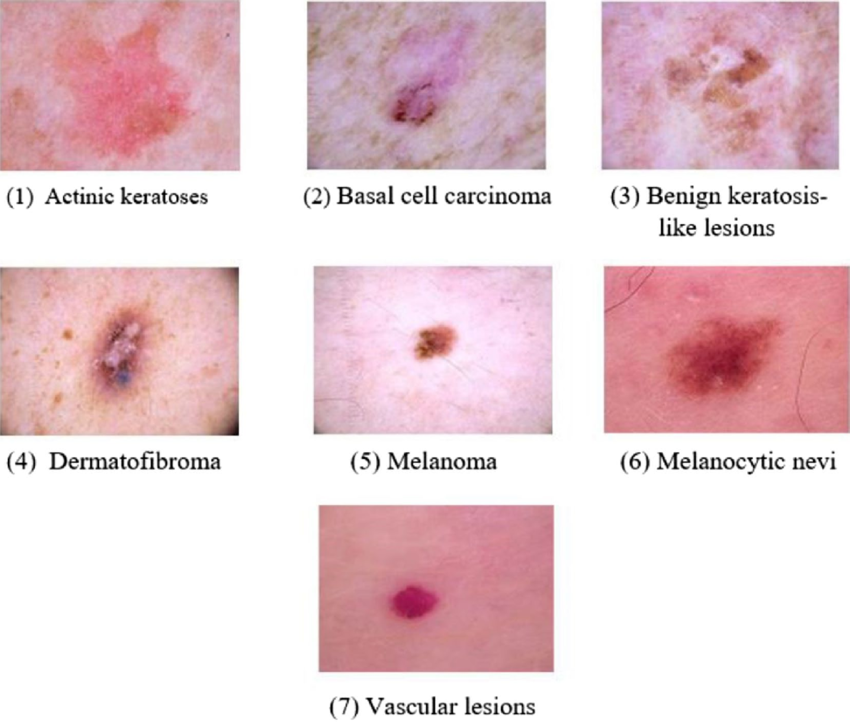

In [135]:
from IPython.display import Image

# Display the image
Image(filename=r"C:\Users\User\Pictures\7.png")



AFTER THIS THE DATSET IS SPLITTING OF DATASET INTO TRAIN TEST AND VALIDATE IS TAKEN PLACE AND LATER MODEL TRAINING IS TAKEN PLACE 